In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

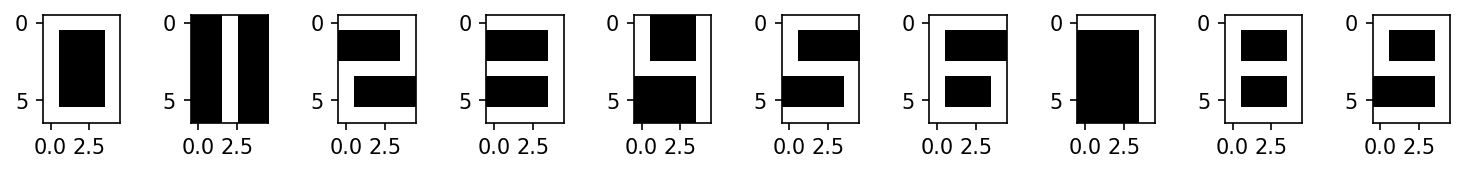

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(150)

nums_mtrx =  np.loadtxt(Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(7, 5), cmap='gray')

plt.tight_layout()
plt.show()

In [3]:
np.random.seed(0)

cells_columns = [f'c{n}' for n in range(35)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.25, 35)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [4]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [5]:
@njit(fastmath=True)
def ident(x: np.ndarray) -> np.ndarray:
    return x


@njit(fastmath=True)
def dIdent(x: np.ndarray) -> np.ndarray:
    return np.ones(x.shape)


@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)


@njit(fastmath=True)
def dTanh(x: np.ndarray) -> np.ndarray:
    return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [6]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, W: np.ndarray, V: np.ndarray, c:np.ndarray, d:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)
    dd = np.zeros(d.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    z = np.zeros(V.shape[2])
    
    for i in prange(xBatch.shape[0]):
        z *= 0

        for j in prange(V.shape[0]):
            h = V[j] @ xBatch[i] + c[j]
            z += V[j].T @ h + d[j]

        z = sigmoid(z)
        y = softmax(W @ z + b)
                
        dLdz = W.T @ (y-yBatch[i]) * z * (1 - z)

        for j in prange(V.shape[0]):    
            dV[j] += np.outer(V[j] @ dLdz, xBatch[i])
            dc[j] += V[j] @ dLdz
            dd[j] += dLdz

        dW += np.outer(y - yBatch[i], z)
        db += y - yBatch[i]
    
    return (dV, dW, dc, dd, db)

In [7]:
class RBMPerceptron:
    def __init__(self, nL:int, nH:int, nIn:int, nOut:int) -> None:
        self.nL = nL
        self.nH = nH
        self.nIn = nIn
        self.nOut = nOut
                
        self.V: np.ndarray = np.random.uniform(-1, 1, (nL, nH, nIn))
        self.c: np.ndarray = np.zeros((nL, nH))
        self.d: np.ndarray = np.zeros((nL, nIn))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        z = np.zeros(self.nIn)
        
        for i in range(self.V.shape[0]):
            h = self.V[i] @ x + self.c[i]
            z += self.V[i].T @ h + self.d[i]
            
        return softmax(self.W @ sigmoid(z) + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx*batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]
            
                dV, dW, dc, dd, db = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.W, self.V, self.c, self.d, self.b)
                
                self.V -= lr*dV
                self.c -= lr*dc
                self.d -= lr*dd

                self.W -= lr*dW
                self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(Ypred), axis=1)
        return np.mean(h)

In [8]:
nL = 5
nH = 5
nIn = 35
nOut = 10

lr = 1e-2
batch_size = 16
max_epoch = 1000

model = RBMPerceptron(nL, nH, nIn, nOut)

print('untrained loss: ', model.loss(xTest, yTest).round(6))

model.train(
    xTrain,
    yTrain,
    lr,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(xTest, yTest).round(6))

TP_count = 0
for x,y in zip(xTest, yTest):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / xTest.shape[0]
print(f"test set accuracy: {round(accuracy*100, 2)}%")

untrained loss:  0.507798
trained loss:  0.000519
test set accuracy: 100.0%


In [9]:
n_samples = 10000
noise_size = 1.0
TP_count = 0

for i in range(n_samples):
    j = i%10
    x = nums_mtrx[j] + np.random.uniform(0, noise_size, 35)
    yPred = model.predict(x)
    TP_count += 1 if j == np.argmax(yPred) else 0

print(f"accuracy: {round(TP_count/n_samples*100, 2)}% ({TP_count} of {n_samples})")

accuracy: 68.54% (6854 of 10000)


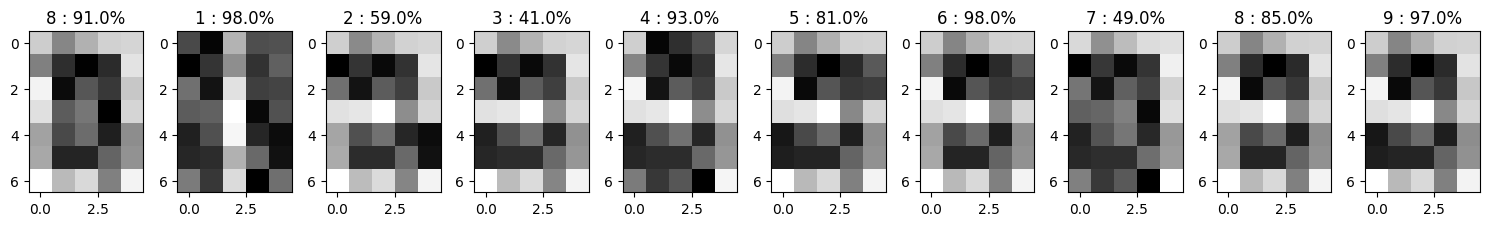

In [10]:
noise_size = 1.0
x_noised = nums_mtrx + np.random.uniform(0, noise_size, 35)

yPred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape((7,5)),  cmap='gray')
    j = np.argmax(yPred[i])
    ax.set_title(f"{j} : {(yPred[i][j]*100).round()}%")

plt.autoscale()
plt.tight_layout()
plt.show()